In [ ]:
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
%matplotlib inline

import math   
import soundfile as sf
import pandas as pd
import os
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import IPython.display as ipd

import csv
from skimage.restoration import denoise_wavelet

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
###### from https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real


def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)

In [ ]:
def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [ ]:
def get_noise_from_sound(signal,noise,SNR):
    RMS_s=math.sqrt(np.mean(signal**2))
    #required RMS of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    
    #current RMS of noise
    RMS_n_current=math.sqrt(np.mean(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    
    return noise

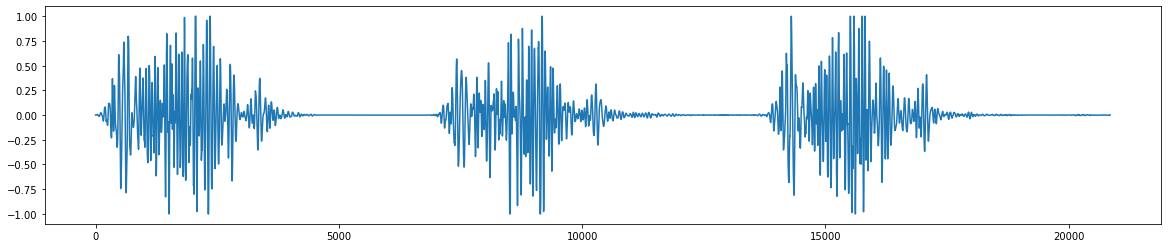

In [ ]:
#########fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data)

In [ ]:
#######noise_len = 2 # seconds
noise = band_limited_noise(min_freq=3000, max_freq = 9000, samples=len(data), samplerate=rate)*5
noise_clip = noise
#noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

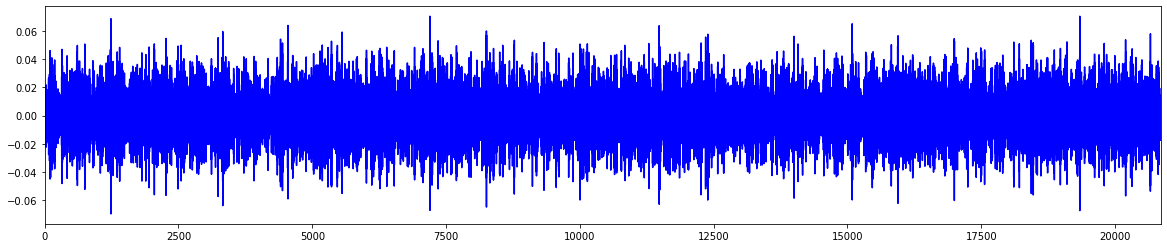

In [ ]:
#########fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(noise, color='blue')
ax.set_xlim((0, len(noise)))
plt.show()
# play back a sample of the song
IPython.display.Audio(data=noise, rate=9000)

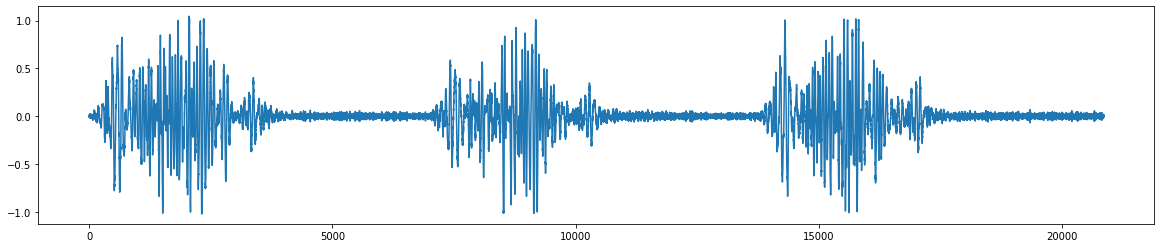

In [ ]:
########fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_band_limited)
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

In [ ]:
import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()


def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=1,
    n_grad_time=2,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    #if verbose:
        #print("Signal recovery:", td(seconds=time.time() - start))
    #if visual:
        #plot_spectrogram(noise_stft_db, title="Noise")
    #if visual:
        #plot_statistics_and_filter(
            #mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        #)
    #if visual:
        #plot_spectrogram(sig_stft_db, title="Signal")
    #if visual:
        #plot_spectrogram(sig_mask, title="Mask applied")
    #if visual:
        #plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    #if visual:
        #plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal


In [ ]:
audio = []
label = []
file_audio = []
path = '/content/gdrive/MyDrive/dataset/'

audio_df = pd.DataFrame()
for files in os.listdir(path):
  path2 = os.path.join(path, files)
  audio_names = files.split(".")[0]
  audio_label = files.split("_")[1]
  audio_files = files

  audio.append(audio_names)
  label.append(audio_label)
  file_audio.append(audio_files)

audio_df['audio_names']=audio
audio_df['audio_label']=label
audio_df['file_audio']=file_audio
audio_df

,audio_names,audio_label,file_audio
0,New_AS_001,AS,New_AS_001.wav
1,New_AS_002,AS,New_AS_002.wav
2,New_AS_003,AS,New_AS_003.wav
3,New_AS_004,AS,New_AS_004.wav
4,New_AS_005,AS,New_AS_005.wav
...,...,...,...
995,New_AS_198,AS,New_AS_198.wav
996,New_AS_199,AS,New_AS_199.wav
997,New_AS_200,AS,New_AS_200.wav
998,New_MVP_199,MVP,New_MVP_199.wav


In [ ]:
def signal(path, audio_df):
  signal_ori = []
  for idx, rows in audio_df.iterrows():
    path2 = os.path.join(path, rows.file_audio)
    signal, sr = librosa.load(path2, mono = True, duration=3, res_type='kaiser_fast')    # Read audio
    signal = np.interp(signal, (signal.min(), signal.max()), (-1, 1))    # norm audio to (1, -1)
    signal_ori.append(signal)

  signal_ori = np.array(signal_ori)
  print(signal_ori.shape)
  return signal_ori

path = '/content/gdrive/MyDrive/dataset/'
signal_ori = signal(path, audio_df)

(1000,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [ ]:
!mkdir audio_denoising_file

In [ ]:
#######import shutil

shutil.rmtree('/content/audio_denoising_file/')

In [ ]:
#hasil denoise dalam bentuk wav
def denoise(path, audio_df):
  #denoising = []
  for idx, rows in audio_df.iterrows():
    path2 = os.path.join(path, rows.file_audio)
    signal, sr = librosa.load(path2, mono = True, duration=3, res_type='kaiser_fast')    # Read audio
    signal = np.interp(signal, (signal.min(), signal.max()), (-1, 1))    # norm audio to (1, -1)

    # Make a noise
    #noise_len = 3 # seconds
    noise = get_white_noise(signal,SNR=10)
    #noise = band_limited_noise(min_freq=4000, max_freq = 12000, samples=len(signal), samplerate=sr)*10
    #noise_clip = noise[:sr*noise_len]
    signal_noise=signal+noise
    
    # Denoising using wavelet
    output = removeNoise(audio_clip=signal_noise, noise_clip=noise, verbose=True, visual=True)
    #temp = np.expand_dims(x_denoise, axis=0)
    #denoising.append(x_denoise)

    temp = '/content/audio_denoising_file/'
    saving_path = os.path.join(temp, rows.file_audio)
    sf.write(saving_path, output, sr, 'PCM_16')

  return noise

  #denoising = np.array(denoising)
  #print(denoising.shape)
  #return denoising

path = '/content/gdrive/MyDrive/dataset/'
noise = denoise(path, audio_df)

Streaming output truncated to the last 5000 lines.
STFT on noise: 0:00:00.011499
STFT on signal: 0:00:00.010376
[11.13438757  9.44996347 10.4180426  ...  9.95035684 10.02795505
 12.90807713] -30.313392884214977
Masking: 0:00:00.009648
Mask convolution: 0:00:00.007805
Mask application: 0:00:00.013332
STFT on noise: 0:00:00.013481
STFT on signal: 0:00:00.013803
[12.06122044  8.38930003  7.82650081 ...  8.07407548  7.48735195
 11.63655849] -30.197637256731333
Masking: 0:00:00.009494
Mask convolution: 0:00:00.008540
Mask application: 0:00:00.012153
STFT on noise: 0:00:00.011113
STFT on signal: 0:00:00.012051
[13.37988279  9.35141793  7.94250589 ...  8.30967087  8.1675683
 11.19536681] -30.633647305014065
Masking: 0:00:00.008828
Mask convolution: 0:00:00.007533
Mask application: 0:00:00.012220
STFT on noise: 0:00:00.011143
STFT on signal: 0:00:00.011412
[13.10625452  9.31483742 10.15189299 ...  8.08362363  7.98894564
  9.64799853] -29.777413571202544
Masking: 0:00:00.011222
Mask convolution

In [ ]:
#hasil denoise dalam bentuk list/array
def list_denoise(path, audio_df):
  signal_denoise_list = []
  for idx, rows in audio_df.iterrows():
    path2 = os.path.join(path, rows.file_audio)
    signal, sr = librosa.load(path2, mono = True, duration=3, res_type='kaiser_fast')    # Read audio
    signal = np.interp(signal, (signal.min(), signal.max()), (-1, 1))    # norm audio to (1, -1)
    signal_denoise_list.append(signal)

  signal_denoise_list = np.array(signal_denoise_list)
  print(signal_denoise_list.shape)
  return signal_denoise_list

path = '/content/audio_denoising_file/'
signal_denoise_list = signal(path, audio_df)

(1000,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [ ]:
!apt-get install rar

In [ ]:
!rar a "/content/audio_denoising_file" "/content/audio_denoising_file"

In [ ]:
snr_list = []
mse_list = []
rmse_list = []
pnsr_list = []

for i in range(0,1000):
  snr = 10*np.log(np.max(signal_denoise_list[0])/np.max(noise))
  mse = mean_squared_error(signal_ori[0], gabung)
  rmse = np.sqrt(mean_squared_error(signal_ori[0], gabung))
  pnsr = 20*np.log10(np.max(signal_ori[0])/np.sqrt(mse))

  snr_list.append(snr)
  mse_list.append(mse) 
  rmse_list.append(rmse)
  pnsr_list.append(pnsr)

print('SNR: {:.4f}'.format(np.max(snr_list)))
print('MSE: {:.4f}'.format(np.mean(mse_list)))
print('RMSE: {:.4f}'.format(np.mean(rmse_list)))
print('PNSR: {:.4f}'.format(np.mean(pnsr_list)))

SNR: 15.8387
MSE: 0.0109
RMSE: 0.1045
PNSR: 19.6194


In [ ]:
signal_ori[0].shape

(57466,)

In [ ]:
signal_denoise_list[0].shape

(57344,)

In [ ]:
i = 0
L = []
while i < 1000 :
  temp = len(signal_ori[i])
  L.append(temp)
  i+=1
print(min(L)) 

25482


In [ ]:
tambahan = np.zeros(shape=(122))

In [ ]:
gabung = np.concatenate((signal_denoise_list[0],tambahan))

In [ ]:
gabung.shape

(57466,)

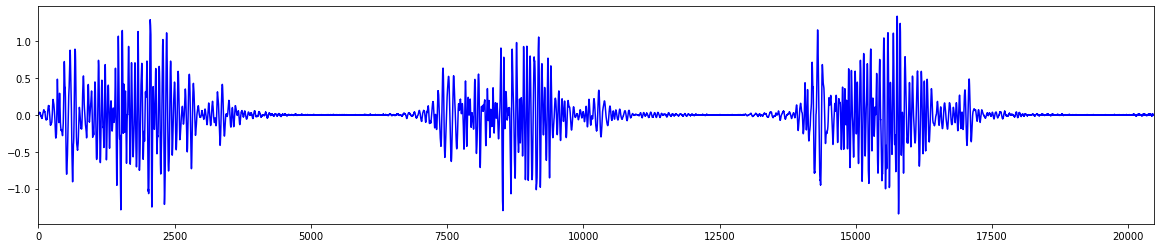

In [ ]:
#####fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(output, color='blue')
ax.set_xlim((0, len(output)))
plt.show()
# play back a sample of the song
IPython.display.Audio(data=output, rate=9000)

In [ ]:
#####from sklearn.metrics import mean_squared_error
import math

print("SNR = " + str(20*np.log10(math.sqrt(np.mean(output**2))/math.sqrt(np.mean(noise**2)))))
print("MSE = ", mean_squared_error(data,noise))
print("PSNR = " + str(20*np.log10(255/mean_squared_error(data,noise))))

SNR = 23.917091053605624
MSE =  0.05435829285878912
PSNR = 73.4254874265905


Ekstraksi dan Klasifikasi

In [ ]:
!ls "/content/gdrive/My Drive/sinyal2"

AS  MR	MS  MVP  N


In [ ]:
from glob import glob

#directories audio abnormal
data_AS = '/content/gdrive/My Drive/sinyal2/AS/'
audio_files_AS = glob(data_AS  + '*.wav')

data_MR = '/content/gdrive/My Drive/sinyal2/MR/'
audio_files_MR = glob(data_MR  + '*.wav')

data_MS = '/content/gdrive/My Drive/sinyal2/MS/'
audio_files_MS = glob(data_MS  + '*.wav')

data_MVP = '/content/gdrive/My Drive/sinyal2/MVP/'
audio_files_MVP = glob(data_MVP  + '*.wav')

#directories of normal audios
data_N = '/content/gdrive/My Drive/sinyal2/AS/'
audio_files_N = glob(data_N  + '*.wav')

print(f'Number of AS audios : {len(audio_files_AS)}')
print(f'Number of MR audios : {len(audio_files_MR)}')
print(f'Number of MS audios : {len(audio_files_MS)}')
print(f'Number of MVP audios : {len(audio_files_MVP)}')
print(f'Number of N audios : {len(audio_files_N)}')

Number of AS audios : 200
Number of MR audios : 200
Number of MS audios : 200
Number of MVP audios : 200
Number of N audios : 200


Load random audio file from Dataset

In [ ]:
pathAS="/content/gdrive/My Drive/sinyal2/AS/New_AS_001.wav"
pathMR="/content/gdrive/My Drive/sinyal2/MR/New_MR_001.wav"
pathMS="/content/gdrive/My Drive/sinyal2/MS/New_MS_001.wav"
pathMVP="/content/gdrive/My Drive/sinyal2/MVP/New_MVP_021.wav"
pathN="/content/gdrive/My Drive/sinyal2/N/New_N_035.wav"
sinyalAS, srAS=librosa.load(pathAS)
sinyalMR, srMR=librosa.load(pathMR)
sinyalMS, srMS=librosa.load(pathMS)
sinyalMVP, srMVP=librosa.load(pathMVP)
sinyalN, srN=librosa.load(pathN)
print(type(sinyalAS), type(srAS))
print(type(sinyalMR), type(srMR))
print(type(sinyalMS), type(srMS))
print(type(sinyalMVP), type(srMVP))
print(type(sinyalN), type(srN))

<class 'numpy.ndarray'> <class 'int'>
<class 'numpy.ndarray'> <class 'int'>
<class 'numpy.ndarray'> <class 'int'>
<class 'numpy.ndarray'> <class 'int'>
<class 'numpy.ndarray'> <class 'int'>


load use wave

In [ ]:
# Load use wave 
import wave
wav1 = wave.open(pathAS)
print("Signal Aortic valve Stenosis (AS)")
print("Sampling (frame) rate = ", wav1.getframerate())
print("Total samples (frames) = ", wav1.getnframes())
print("Duration = ", wav1.getnframes()/wav1.getframerate())
print("----------------------------------")
wav2 = wave.open(pathMR)
print("Signal Mitral valve Regurgitation (MR)")
print("Sampling (frame) rate = ", wav2.getframerate())
print("Total samples (frames) = ", wav2.getnframes())
print("Duration = ", wav2.getnframes()/wav2.getframerate())
print("----------------------------------")
wav3 = wave.open(pathMS)
print("Signal  Mitral valve Stenosis (MS)")
print("Sampling (frame) rate = ", wav3.getframerate())
print("Total samples (frames) = ", wav3.getnframes())
print("Duration = ", wav3.getnframes()/wav3.getframerate())
print("----------------------------------")
wav4 = wave.open(pathMVP)
print("Signal Murmur in systole (MVP)")
print("Sampling (frame) rate = ", wav4.getframerate())
print("Total samples (frames) = ", wav4.getnframes())
print("Duration = ", wav4.getnframes()/wav4.getframerate())
print("----------------------------------")
wav5 = wave.open(pathN)
print("Signal Normal (N)")
print("Sampling (frame) rate = ", wav5.getframerate())
print("Total samples (frames) = ", wav5.getnframes())
print("Duration = ", wav5.getnframes()/wav5.getframerate())

Signal Aortic valve Stenosis (AS)
Sampling (frame) rate =  22050
Total samples (frames) =  57344
Duration =  2.6006349206349206
----------------------------------
Signal Mitral valve Regurgitation (MR)
Sampling (frame) rate =  22050
Total samples (frames) =  46080
Duration =  2.089795918367347
----------------------------------
Signal  Mitral valve Stenosis (MS)
Sampling (frame) rate =  22050
Total samples (frames) =  65024
Duration =  2.948934240362812
----------------------------------
Signal Murmur in systole (MVP)
Sampling (frame) rate =  22050
Total samples (frames) =  55808
Duration =  2.5309750566893423
----------------------------------
Signal Normal (N)
Sampling (frame) rate =  22050
Total samples (frames) =  46080
Duration =  2.089795918367347


ekstraksi

In [ ]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=8dc06d02fc490255d0940e88e7de3936ee583c425d9cef790156321443eb538c
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
#ekstrak MFCCs
from python_speech_features import mfcc

In [ ]:
mfccs = mfcc(sinyalAS, srAS)
print('\nMFCC:\nNumber of windows =', mfccs.shape[0])
print('Length of each feature =', mfccs.shape[1])


MFCC:
Number of windows = 258
Length of each feature = 13



Filter bank:
Number of windows = 258
Length of each feature = 26


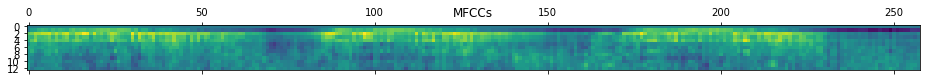

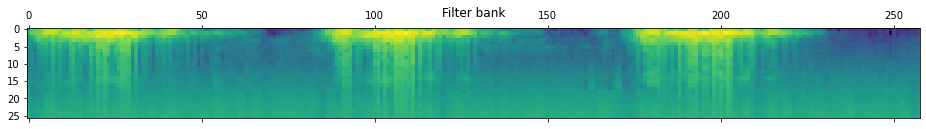

In [ ]:
from python_speech_features import logfbank

mfccs = mfccs.T
plt.matshow(mfccs)
plt.title('MFCCs')

filterbank_features = logfbank(sinyalAS, srAS)

print('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print('Length of each feature =', filterbank_features.shape[1])

filterbank_features = filterbank_features.T
plt.matshow(filterbank_features)
plt.title('Filter bank')
plt.show()

In [ ]:
# Get more components
mfccs1 = librosa.feature.mfcc(sinyalAS, sr=srAS, n_mfcc=39)
mfccs2 = librosa.feature.mfcc(sinyalMR, sr=8000, n_mfcc=26, n_fft=2048, hop_length=512, n_mels=128)
mfccs3 = librosa.feature.mfcc(sinyalMS, sr=8000, n_mfcc=26, n_fft=2048, hop_length=512, n_mels=128)
mfccs4 = librosa.feature.mfcc(sinyalMVP, sr=8000, n_mfcc=26, n_fft=2048, hop_length=512, n_mels=128)
mfccs5 = librosa.feature.mfcc(sinyalN, sr=8000, n_mfcc=26, n_fft=2048, hop_length=512, n_mels=128)
print (mfccs1)

[[-401.0112     -386.44196    -366.06552    ... -468.8481
  -465.08807    -460.62222   ]
 [  79.135605    116.31262     138.86508    ...    8.830587
    13.58535      18.813812  ]
 [  69.77908      90.62007     102.34035    ...    6.0867214
     9.697851     13.143385  ]
 ...
 [  -2.8153632    -0.54323906   -2.1184058  ...    3.887119
     3.6415694     3.52038   ]
 [  -4.217861     -2.8161745    -3.6120389  ...    2.9271812
     3.8227441     2.5615227 ]
 [  -5.236478     -5.661874     -5.671403   ...    2.2139153
     4.087053      1.9923458 ]]


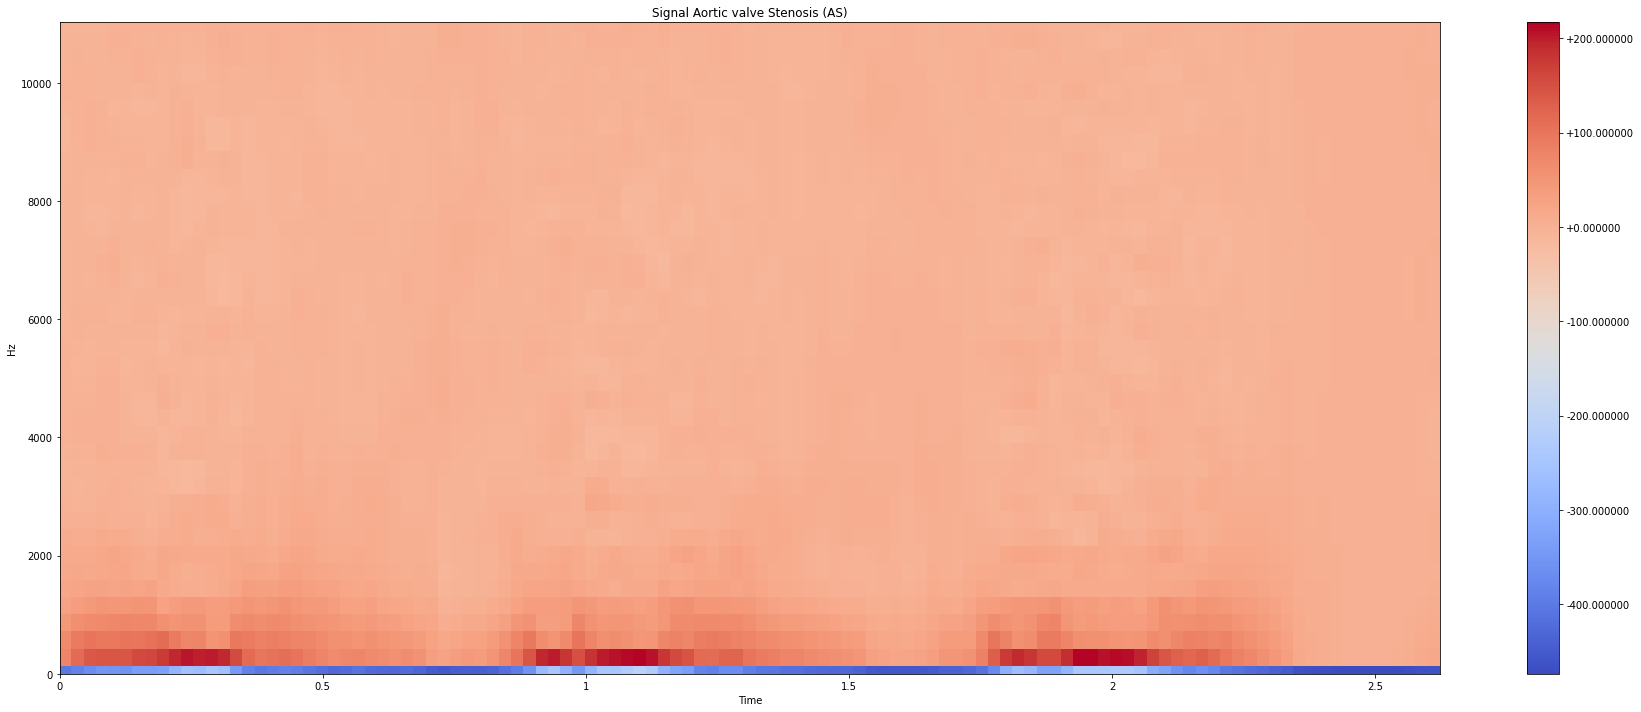

In [ ]:
import librosa.display
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfccs1,
                         sr=srAS,
                         x_axis='time',
                         y_axis='hz')
plt.colorbar(format="%+2f")
plt.title("Signal Aortic valve Stenosis (AS)")
plt.tight_layout()

In [ ]:
delta_mfccs = librosa.feature.delta(mfccs1)
delta2_mfccs = librosa.feature.delta(mfccs1, order=2)

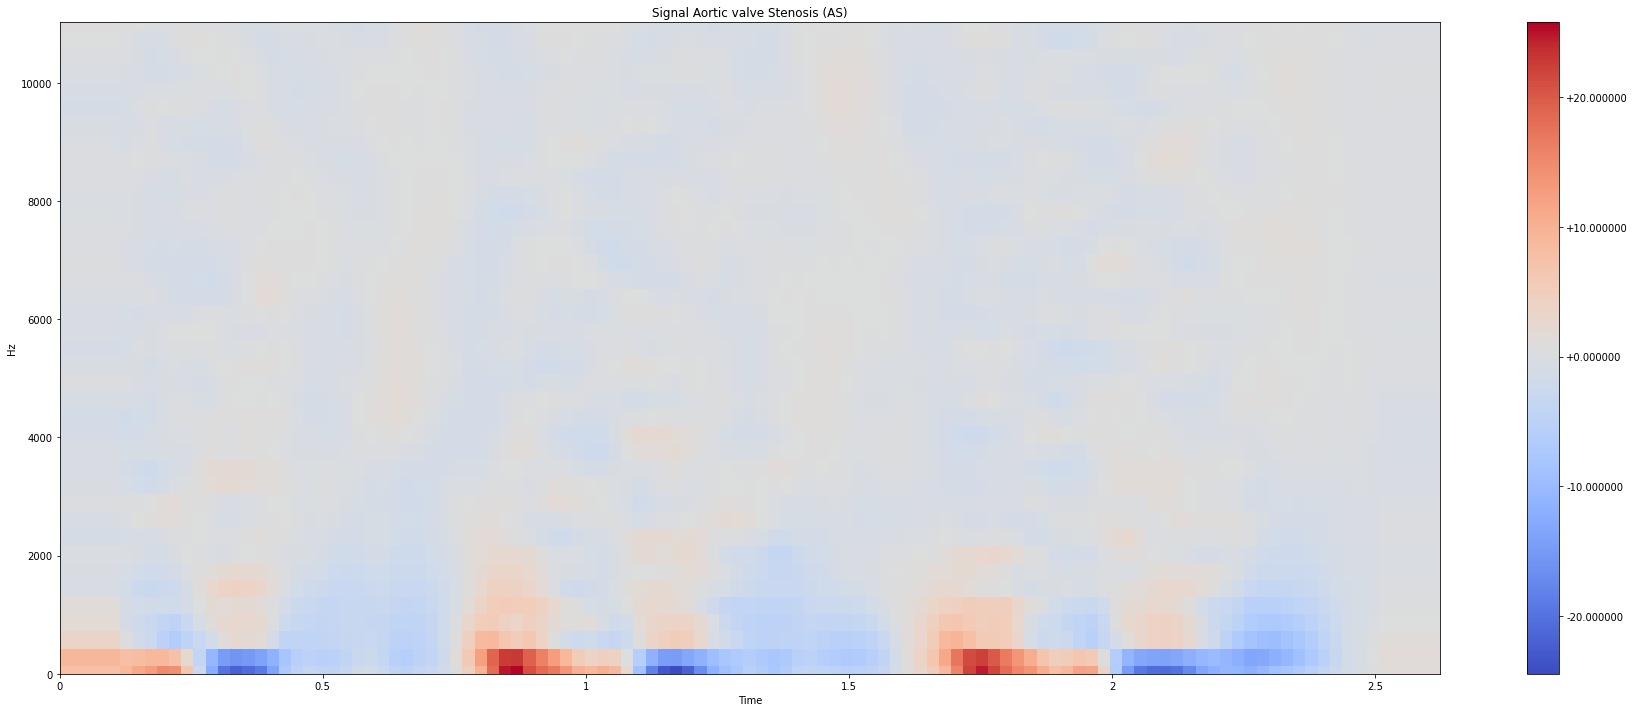

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta_mfccs,
                         sr=srAS,
                         x_axis='time',
                         y_axis='hz')
plt.colorbar(format="%+2f")
plt.title("Signal Aortic valve Stenosis (AS)")
plt.tight_layout()

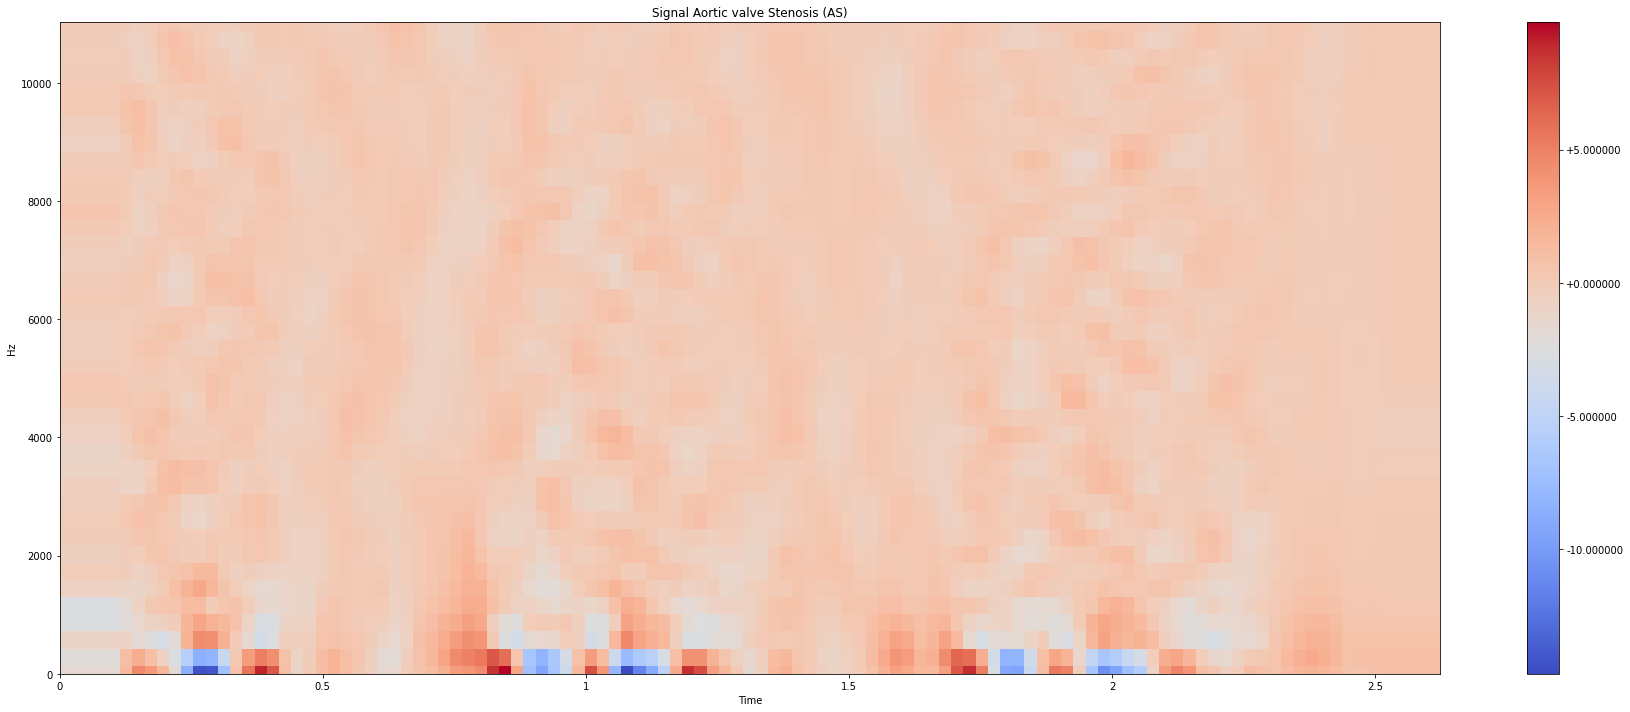

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta2_mfccs,
                         sr=srAS,
                         x_axis='time',
                         y_axis='hz')
plt.colorbar(format="%+2f")
plt.title("Signal Aortic valve Stenosis (AS)")
plt.tight_layout()

In [ ]:
comprehensive_mfccs = np.concatenate((mfccs1, delta_mfccs, delta2_mfccs))

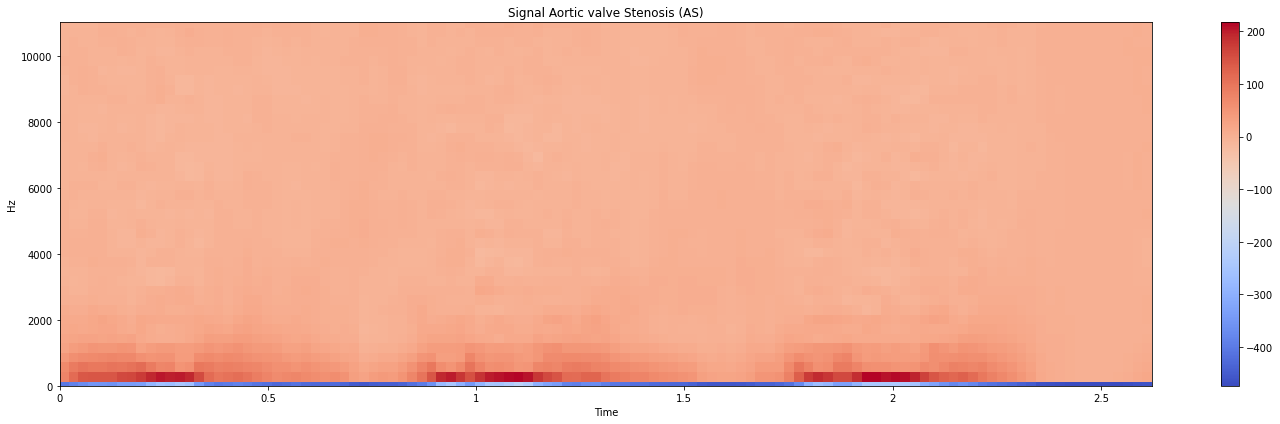

In [ ]:
plt.figure(figsize=(20, 6))
librosa.display.specshow(mfccs1,
                         sr=srAS,
                         x_axis='time',
                         y_axis='hz')
plt.colorbar()
plt.title("Signal Aortic valve Stenosis (AS)")
plt.tight_layout()
plt.savefig('MFCCs_AS.png')

Buat Dataset ekstraksi fitur

In [ ]:
header = 'filename' 
for i in range(1, 40):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
file = open('MFCCs.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'AS MR MS MVP N'.split()
for g in genres:
    for filename in os.listdir(f'/content/gdrive/My Drive/sinyal2/{g}'):
        signal = f'/content/gdrive/My Drive/sinyal2/{g}/{filename}'
        # use kaiser_fast technique for faster extraction
        y, sr = librosa.load(signal, mono=True, duration=3, res_type='kaiser_fast')
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=39)
        to_append = f'{filename}'  
        for e in mfcc:
            to_append += f' {np.mean(e.T,axis=0)}'
        to_append += f' {g}'
        file = open('MFCCs.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

new section

In [ ]:
data1_1 = pd.read_csv('MFCCs.csv')
data1_1.head()

,filename,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,mfcc21,mfcc22,mfcc23,mfcc24,mfcc25,mfcc26,mfcc27,mfcc28,mfcc29,mfcc30,mfcc31,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,label
0,New_AS_010.wav,-376.043518,106.295990,57.500530,42.911480,31.351070,15.852449,12.290703,11.958051,6.418272,4.067505,4.248457,1.041451,-0.226326,1.070155,-0.585137,-2.355379,-1.317198,-0.467641,-0.843059,-1.382639,-2.106587,-2.736468,-3.091484,-3.451013,-3.819205,-3.906836,-3.822701,-3.594757,-3.283656,-3.276018,-3.263325,-2.922728,-2.631814,-2.670223,-2.328532,-2.008196,-2.314191,-2.186965,-1.864896,AS
1,New_AS_004.wav,-377.602844,106.793625,55.042526,41.370399,30.821354,15.653506,12.235271,11.403704,5.242695,3.062470,3.795156,1.002769,-0.510431,-0.044805,-1.939495,-2.727813,-1.060764,-0.837574,-1.574739,-2.028060,-2.594326,-2.943056,-3.363646,-3.903311,-4.276028,-4.218855,-3.986422,-3.768454,-4.171974,-4.398596,-3.609244,-3.270957,-3.502469,-3.385169,-2.963565,-2.704460,-2.406108,-2.360073,-2.018677,AS
2,New_AS_005.wav,-377.032013,105.771057,56.298222,42.247124,31.521204,15.352294,12.112995,12.230271,6.238399,3.879854,4.565682,1.259081,-0.619873,0.455645,-1.149448,-2.552243,-1.239700,-1.008509,-2.066364,-2.465727,-2.695444,-2.863956,-2.664459,-2.916572,-3.618780,-3.948229,-4.197029,-4.299210,-4.035447,-3.860793,-3.565456,-3.111119,-2.953849,-2.620776,-2.215338,-2.074127,-1.682687,-1.629992,-2.077183,AS
3,New_AS_003.wav,-375.953094,107.924744,55.507645,42.004814,31.560362,16.042618,12.633139,12.079575,6.405556,4.990349,5.705853,2.006188,0.061785,0.894174,-0.255222,-1.296451,-0.684520,-0.895744,-1.368730,-0.961664,-1.506244,-2.328094,-2.417183,-2.893748,-3.214900,-3.103868,-3.524229,-3.691469,-3.384206,-3.301479,-2.962133,-2.648889,-2.671551,-2.338737,-1.561257,-1.529243,-1.611079,-1.341535,-0.936055,AS
4,New_AS_001.wav,-376.197144,106.222321,58.165489,42.345810,30.945478,15.886915,11.694269,11.226764,6.160518,4.018240,4.428489,1.620175,-0.383050,-0.038993,-0.662765,-1.072524,-0.483649,-1.082400,-1.756947,-1.421417,-1.568365,-2.395972,-2.872362,-2.901250,-2.715084,-2.960688,-3.856724,-3.952057,-3.390164,-3.193473,-2.902700,-2.826046,-2.950919,-2.544439,-2.004173,-1.818696,-1.360725,-0.744255,-0.501300,AS


prepare data untuk seleksi fitur

In [ ]:
print('MFCCs :',data1_1.shape)

MFCCs : (1000, 41)


In [ ]:
data1_1 = data1_1.drop(['filename'], axis=1)
data1_1.head()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,mfcc21,mfcc22,mfcc23,mfcc24,mfcc25,mfcc26,mfcc27,mfcc28,mfcc29,mfcc30,mfcc31,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,label
0,-376.043518,106.295990,57.500530,42.911480,31.351070,15.852449,12.290703,11.958051,6.418272,4.067505,4.248457,1.041451,-0.226326,1.070155,-0.585137,-2.355379,-1.317198,-0.467641,-0.843059,-1.382639,-2.106587,-2.736468,-3.091484,-3.451013,-3.819205,-3.906836,-3.822701,-3.594757,-3.283656,-3.276018,-3.263325,-2.922728,-2.631814,-2.670223,-2.328532,-2.008196,-2.314191,-2.186965,-1.864896,AS
1,-377.602844,106.793625,55.042526,41.370399,30.821354,15.653506,12.235271,11.403704,5.242695,3.062470,3.795156,1.002769,-0.510431,-0.044805,-1.939495,-2.727813,-1.060764,-0.837574,-1.574739,-2.028060,-2.594326,-2.943056,-3.363646,-3.903311,-4.276028,-4.218855,-3.986422,-3.768454,-4.171974,-4.398596,-3.609244,-3.270957,-3.502469,-3.385169,-2.963565,-2.704460,-2.406108,-2.360073,-2.018677,AS
2,-377.032013,105.771057,56.298222,42.247124,31.521204,15.352294,12.112995,12.230271,6.238399,3.879854,4.565682,1.259081,-0.619873,0.455645,-1.149448,-2.552243,-1.239700,-1.008509,-2.066364,-2.465727,-2.695444,-2.863956,-2.664459,-2.916572,-3.618780,-3.948229,-4.197029,-4.299210,-4.035447,-3.860793,-3.565456,-3.111119,-2.953849,-2.620776,-2.215338,-2.074127,-1.682687,-1.629992,-2.077183,AS
3,-375.953094,107.924744,55.507645,42.004814,31.560362,16.042618,12.633139,12.079575,6.405556,4.990349,5.705853,2.006188,0.061785,0.894174,-0.255222,-1.296451,-0.684520,-0.895744,-1.368730,-0.961664,-1.506244,-2.328094,-2.417183,-2.893748,-3.214900,-3.103868,-3.524229,-3.691469,-3.384206,-3.301479,-2.962133,-2.648889,-2.671551,-2.338737,-1.561257,-1.529243,-1.611079,-1.341535,-0.936055,AS
4,-376.197144,106.222321,58.165489,42.345810,30.945478,15.886915,11.694269,11.226764,6.160518,4.018240,4.428489,1.620175,-0.383050,-0.038993,-0.662765,-1.072524,-0.483649,-1.082400,-1.756947,-1.421417,-1.568365,-2.395972,-2.872362,-2.901250,-2.715084,-2.960688,-3.856724,-3.952057,-3.390164,-3.193473,-2.902700,-2.826046,-2.950919,-2.544439,-2.004173,-1.818696,-1.360725,-0.744255,-0.501300,AS


In [ ]:
data1_1.dtypes

mfcc1     float64
mfcc2     float64
mfcc3     float64
mfcc4     float64
mfcc5     float64
mfcc6     float64
mfcc7     float64
mfcc8     float64
mfcc9     float64
mfcc10    float64
mfcc11    float64
mfcc12    float64
mfcc13    float64
mfcc14    float64
mfcc15    float64
mfcc16    float64
mfcc17    float64
mfcc18    float64
mfcc19    float64
mfcc20    float64
mfcc21    float64
mfcc22    float64
mfcc23    float64
mfcc24    float64
mfcc25    float64
mfcc26    float64
mfcc27    float64
mfcc28    float64
mfcc29    float64
mfcc30    float64
mfcc31    float64
mfcc32    float64
mfcc33    float64
mfcc34    float64
mfcc35    float64
mfcc36    float64
mfcc37    float64
mfcc38    float64
mfcc39    float64
label      object
dtype: object

In [ ]:
data1_1['label'] = pd.Categorical(data1_1['label'])

In [ ]:
y1 = LabelEncoder().fit_transform(data1_1.iloc[:, -1])

In [ ]:
X1 = StandardScaler().fit_transform(np.array(data1_1.iloc[:, :-1], dtype = float))

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=127)

In [ ]:
X1_train.shape, X1_test.shape

((800, 39), (200, 39))

fitur seleksi

In [ ]:
#normalization
x_train_N = (X1_train-X1_train.mean())/(X1_train.max()-X1_train.min())
x_test_N = (X1_test-X1_test.mean())/(X1_test.max()-X1_test.min())

In [ ]:
def calculate_sensitivity_specificity(y_test, y_pred):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred == 1) & (actual_pos)
    false_pos = (y_pred == 1) & (actual_neg)
    true_neg = (y_pred == 0) & (actual_neg)
    false_neg = (y_pred == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy

In [ ]:
# Using PCA from sklearn PCA
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
# initialize model
pca = PCA(n_components=0.99)
# fit to training data
pca.fit(X1_train)
# transform
X_pca = pca.transform(X1_train)

In [ ]:
pca = PCA(n_components=39)
# fit to training data
pca.fit(X1_train)
# transform
X_train_pca = pca.transform(X1_train)

X_test_pca = pca.transform(X1_test)

In [ ]:
X1_train.shape
X1_test.shape

(200, 39)

In [ ]:
pca = PCA(n_components=1)
X_train = pca.fit_transform(X1_train)
X_test = pca.transform(X1_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: n {confusion_matrix(y_train, pred)}n")
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: n {confusion_matrix(y_test, pred)}n")

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC(loss='hinge', dual=True)
model.fit(X1_train, y1_train)
print_score(model, X1_train, y1_train, X1_test, y1_test, train=True)
print_score(model, X1_train, y1_train, X1_test, y1_test, train=False)

Train Result:n================================================
Accuracy Score: 91.00%
_______________________________________________
CLASSIFICATION REPORT:n                    0           1  ...   macro avg  weighted avg
precision    0.917722    0.903226  ...    0.909562      0.909713
recall       0.878788    0.909091  ...    0.910622      0.910000
f1-score     0.897833    0.906149  ...    0.909128      0.908884
support    165.000000  154.000000  ...  800.000000    800.000000

[4 rows x 8 columns]
_______________________________________________
Confusion Matrix: n [[145   4   4  12   0]
 [  4 140   7   0   3]
 [  4   0 150   3   0]
 [  5  11   7 132   8]
 [  0   0   0   0 161]]n
Test Result:n================================================
Accuracy Score: 91.50%
_______________________________________________
CLASSIFICATION REPORT:n                   0          1          2  ...  accuracy   macro avg  weighted avg
precision   0.864865   0.933333   0.952381  ...     0.915    0.913329  

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


klasifikasi

In [ ]:
X1_train.shape
X1_test.shape

(200, 39)

In [ ]:
pca = PCA(n_components=39)
X_train = pca.fit_transform(X1_train)
X_test = pca.transform(X1_test)

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']} 
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 10, scoring='accuracy')
  
# fitting the model for grid search
grid.fit(X_train, y1_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START C=0.1, gamma=1, kernel=rbf.................................
[CV 1/5; 1/50] END ..C=0.1, gamma=1, kernel=rbf;, score=0.212 total time=   0.1s
[CV 2/5; 1/50] START C=0.1, gamma=1, kernel=rbf.................................
[CV 2/5; 1/50] END ..C=0.1, gamma=1, kernel=rbf;, score=0.219 total time=   0.1s
[CV 3/5; 1/50] START C=0.1, gamma=1, kernel=rbf.................................
[CV 3/5; 1/50] END ..C=0.1, gamma=1, kernel=rbf;, score=0.206 total time=   0.1s
[CV 4/5; 1/50] START C=0.1, gamma=1, kernel=rbf.................................
[CV 4/5; 1/50] END ..C=0.1, gamma=1, kernel=rbf;, score=0.212 total time=   0.1s
[CV 5/5; 1/50] START C=0.1, gamma=1, kernel=rbf.................................
[CV 5/5; 1/50] END ..C=0.1, gamma=1, kernel=rbf;, score=0.212 total time=   0.1s
[CV 1/5; 2/50] START C=0.1, gamma=1, kernel=linear..............................
[CV 1/5; 2/50] END C=0.1, gamma=1, kernel=linea

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=10)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


In [ ]:
Dataframe = pd.DataFrame(grid.cv_results_)
Dataframe = Dataframe.drop(['std_test_score','split4_test_score','split3_test_score','split2_test_score','split1_test_score','split0_test_score','params','std_score_time','mean_score_time','std_fit_time','mean_fit_time'],axis=1)
Dataframe.sort_values('rank_test_score', ascending="True")
csvpak = Dataframe.sort_values('rank_test_score', ascending="True")
csvpak.to_csv('datatuning.csv')

In [ ]:
grid_predictions = grid.predict(X_test)

print(confusion_matrix(y1_test, grid_predictions))  
# print classification report
print(classification_report(y1_test, grid_predictions, target_names=['Sinyal AS', 'Sinyal MR','Sinyal MS','Sinyal MVP','Sinyal N']))
print("Accuracy : ",accuracy_score(y1_test, grid_predictions))

[[34  0  0  1  0]
 [ 0 46  0  0  0]
 [ 1  0 42  0  0]
 [ 2  0  0 35  0]
 [ 0  0  0  0 39]]
              precision    recall  f1-score   support

   Sinyal AS       0.92      0.97      0.94        35
   Sinyal MR       1.00      1.00      1.00        46
   Sinyal MS       1.00      0.98      0.99        43
  Sinyal MVP       0.97      0.95      0.96        37
    Sinyal N       1.00      1.00      1.00        39

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

Accuracy :  0.98


In [ ]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(y1_test, grid_predictions)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 1.0
Specificity: 0.9714285714285714
Accuracy: 0.98


In [ ]:
#no pca
from sklearn import svm
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']} 
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 10, scoring='accuracy')
  
# fitting the model for grid search
grid.fit(X1_train, y1_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START C=0.1, gamma=1, kernel=rbf.................................
[CV 1/5; 1/50] END ..C=0.1, gamma=1, kernel=rbf;, score=0.212 total time=   0.1s
[CV 2/5; 1/50] START C=0.1, gamma=1, kernel=rbf.................................
[CV 2/5; 1/50] END ..C=0.1, gamma=1, kernel=rbf;, score=0.219 total time=   0.1s
[CV 3/5; 1/50] START C=0.1, gamma=1, kernel=rbf.................................
[CV 3/5; 1/50] END ..C=0.1, gamma=1, kernel=rbf;, score=0.206 total time=   0.1s
[CV 4/5; 1/50] START C=0.1, gamma=1, kernel=rbf.................................
[CV 4/5; 1/50] END ..C=0.1, gamma=1, kernel=rbf;, score=0.212 total time=   0.1s
[CV 5/5; 1/50] START C=0.1, gamma=1, kernel=rbf.................................
[CV 5/5; 1/50] END ..C=0.1, gamma=1, kernel=rbf;, score=0.212 total time=   0.1s
[CV 1/5; 2/50] START C=0.1, gamma=1, kernel=linear..............................
[CV 1/5; 2/50] END C=0.1, gamma=1, kernel=linea

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=10)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


In [ ]:
Dataframe = pd.DataFrame(grid.cv_results_)
Dataframe = Dataframe.drop(['std_test_score','split4_test_score','split3_test_score','split2_test_score','split1_test_score','split0_test_score','params','std_score_time','mean_score_time','std_fit_time','mean_fit_time'],axis=1)
Dataframe.sort_values('rank_test_score', ascending="True")
csvpak = Dataframe.sort_values('rank_test_score', ascending="True")
csvpak.to_csv('datatuning.csv')

In [ ]:
grid_predictions = grid.predict(X1_test)

print(confusion_matrix(y1_test, grid_predictions))  
# print classification report
print(classification_report(y1_test, grid_predictions, target_names=['Sinyal AS', 'Sinyal MR','Sinyal MS','Sinyal MVP','Sinyal N']))
print("Accuracy : ",accuracy_score(y1_test, grid_predictions))

[[34  0  0  1  0]
 [ 0 46  0  0  0]
 [ 1  0 42  0  0]
 [ 2  0  0 35  0]
 [ 0  0  0  0 39]]
              precision    recall  f1-score   support

   Sinyal AS       0.92      0.97      0.94        35
   Sinyal MR       1.00      1.00      1.00        46
   Sinyal MS       1.00      0.98      0.99        43
  Sinyal MVP       0.97      0.95      0.96        37
    Sinyal N       1.00      1.00      1.00        39

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

Accuracy :  0.98


In [ ]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(y1_test, grid_predictions)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 1.0
Specificity: 0.9714285714285714
Accuracy: 0.98
